# Stock Prediction using Linear Regression, Ridge and Lasso

In [0]:
import datetime
from time import sleep
import math
import numpy as np
import matplotlib.pyplot as plt

import pandas_datareader.data as web
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

### Data initialisation

In [0]:
# This should be the first day you want to analize based on IPO for example
start_date = datetime.datetime(2011, 2, 16)
# Analize stock until today
end_date = datetime.datetime.today()
# Stock name to analize
stock_name = 'SFTBY'

### Data read from Yahoo Finance

In [111]:
df = pd.DataFrame()
try:
    df = web.DataReader(stock_name, 'yahoo', start_date, end_date)
except Exception:
    sleep(1)
   
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,22.790001,22.549999,22.790001,22.650000,555400.0,22.650000
2019-09-03,22.379999,22.110001,22.110001,22.200001,525400.0,22.200001
2019-09-04,22.450001,22.280001,22.320000,22.370001,1255600.0,22.370001
2019-09-05,22.559999,22.080000,22.400000,22.180000,1529700.0,22.180000
2019-09-06,21.969999,21.309999,21.969999,21.480000,1132400.0,21.480000


In [112]:
# We will use the Adj Close price and Volume as features to predict the stock price
df_reg = df.loc[:,['Adj Close', 'Volume']]
# And also create the features High Low Percentage and Percentage Change
df_reg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df_reg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
df_reg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-30,22.650000,555400.0,1.059610,-0.614310
2019-09-03,22.200001,525400.0,1.216210,0.407056
2019-09-04,22.370001,1255600.0,0.759947,0.224019
2019-09-05,22.180000,1529700.0,2.164110,-0.982140
2019-09-06,21.480000,1132400.0,3.072625,-2.230313


## Training and Preprocessing

In [89]:
# Exclude 1% of the last days of data to use it as reference for testing
forecast_data = int(math.ceil(0.01 * len(df_reg)))
df_reg['Predict'] = df_reg['Adj Close'].shift(-forecast_data)
X = np.array(df_reg.drop(['Predict'], 1))
Y = np.array(df_reg['Predict'])

# Normalization of data
X = preprocessing.scale(X)

# Set the training and testing data
X_test = X[-forecast_data:]
X_train = X[:-forecast_data]

Y_test = Y[-forecast_data:]
Y_train = Y[:-forecast_data]

X_test, X_train, Y_test, Y_train

(array([[ 2.01572417,  0.68042591,  2.74684863,  2.0766097 ],
        [ 1.77194853,  2.27451898,  0.81871857,  1.10911631],
        [ 1.61888032,  0.3775659 , -0.25125219, -0.6863657 ],
        [ 1.56029835,  0.03854756, -0.30755319, -0.47038954],
        [ 1.61321099,  0.54014246,  0.85946265,  1.3449094 ],
        [ 1.48659891,  0.44553269, -0.00526833, -1.08110382],
        [ 1.60565225,  0.51227607, -0.31760121, -0.09477389],
        [ 1.59620337,  0.23469971,  0.6241133 ,  0.62196997],
        [ 1.59620337,  0.0087781 ,  0.03249335, -0.16954561],
        [ 1.53006267,  0.02155586, -0.23007222, -1.07137171],
        [ 1.42801731,  0.48903143, -0.38553094, -0.90404376],
        [ 1.33164092,  0.93489357,  0.6718915 , -2.04045549],
        [ 1.19935951,  2.45164043,  2.30390546, -2.68754465],
        [ 1.27494909,  0.51485881, -0.23918444,  0.31057798],
        [ 1.3221924 ,  0.6034875 ,  0.41665793, -1.08076115],
        [ 1.33542047,  0.13397293,  0.11536537,  0.95138854],
        

## Predicting

### Linear Regression

In [90]:
lnr = LinearRegression(n_jobs=-1)
lnr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

### Ridge

In [91]:
rdg = Ridge(alpha=0.5)
rdg.fit(X_train, Y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### Lasso

In [92]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Predict the three models

In [186]:
last_date = df.iloc[-1].name
last_unit_date = last_date
next_unit_date = last_unit_date + datetime.timedelta(days=1)

forecast_lnr = lnr.predict(X_test)
forecast_rdg = rdg.predict(X_test)
forecast_lasso = lasso.predict(X_test)

df_reg['Forecast LNR'] = np.nan
df_reg['Forecast RDG'] = np.nan
df_reg['Forecast LASSO'] = np.nan

# Add the values to the respective column
for i in forecast_lnr:
    next_date = next_unit_date
    next_unit_date += datetime.timedelta(days=1)
    df_reg.loc[next_date] = [np.nan for _ in range(len(df_reg.columns))]
    df_reg['Forecast LNR'].loc[next_date] = i
    
next_unit_date = last_unit_date + datetime.timedelta(days=1)
for i in forecast_rdg:
    next_date = next_unit_date
    next_unit_date += datetime.timedelta(days=1)
    df_reg['Forecast RDG'].loc[next_date] = i
    
next_unit_date = last_unit_date + datetime.timedelta(days=1)
for i in forecast_lasso:
    next_date = next_unit_date
    next_unit_date += datetime.timedelta(days=1)
    df_reg['Forecast LASSO'].loc[next_date] = i
    
df_reg.tail()

,Adj Close,Volume,HL_PCT,PCT_change,Forecast LNR,Forecast RDG,Forecast LASSO
Date,,,,,,,
2019-09-24,NaN,NaN,NaN,NaN,22.540630,22.538695,22.370293
2019-09-25,NaN,NaN,NaN,NaN,22.130585,22.128717,21.945038
2019-09-26,NaN,NaN,NaN,NaN,22.104617,22.103303,22.105690
2019-09-27,NaN,NaN,NaN,NaN,21.938938,21.937700,21.926138
2019-09-28,NaN,NaN,NaN,NaN,21.389136,21.387684,21.264628


### Evaluation 

In [0]:
# Find the confidence in each model
Y_test = df_reg['Adj Close']

_, X_test_lnr, _, Y_test_lnr = train_test_split(X, Y_test[:-forecast_data])
_, X_test_rdg, _, Y_test_rdg = train_test_split(X, Y_test[:-forecast_data])
_, X_test_lasso, _, Y_test_lasso = train_test_split(X, Y_test[:-forecast_data])

score_lnr = lnr.score(X_test_lnr, Y_test_lnr)
score_rdg = rdg.score(X_test_rdg, Y_test_rdg)
score_lasso = lasso.score(X_test_lasso, Y_test_lasso)

# Select the model with the best confidence
if (score_lnr >= score_rdg and score_lnr >= score_lasso):
    method = 'Forecast LNR'
elif (score_rdg >= score_lnr and score_rdg >= score_lasso):
    method = 'Forecast RDG'
else:
    method = 'Forecast LASSO'

## Plotting

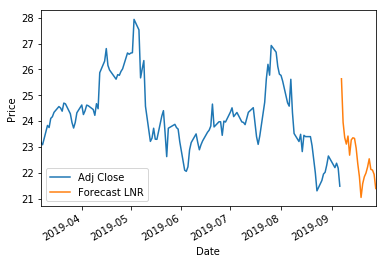

In [189]:
# Plot the values
# The blue line is for the actual price and the orange is the predicted price
# for the next 1% of the calculated time
plt.figure()
df_reg['Adj Close'].tail(150).plot()
df_reg[method].tail(150).plot()
plt.legend(loc=3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()